# Library

In [75]:
# Native library
import copy
import warnings
warnings.filterwarnings('ignore')

# Save object
import joblib

# Data management
import numpy as np
import pandas as pd
import xarray as xr

# Data prepocessing
from sklearn.preprocessing import MinMaxScaler

# from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Hyperoptimization
from sklearn.model_selection import GridSearchCV

# Regressor models
from xgboost import XGBRegressor

# Model evaluation
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

In [76]:
# Target variable
TARGET = "Rice Yield (kg/ha)"
S_COLUMNS = ['ndvi', 'savi', 'evi', 'rep', 'osavi', 'rdvi', 'mtvi1', 'lswi']
G_COLUMNS = ['Field size (ha)', 'Rice Crop Intensity(D=Double, T=Triple)']
M_COLUMNS = ['tempmax', 'tempmin', 'temp', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'windspeed', 'winddir', 
             'sealevelpressure', 'cloudcover', 'solarradiation', 'solarenergy', 'uvindex', 'moonphase', 'solarexposure']

# Import Data

In [77]:
xdf = xr.open_dataset('../../data/processed/adaptative_factor_2/train_filter_processed.nc')
xdf = xr.merge([xdf[G_COLUMNS], xdf[M_COLUMNS].sel(datetime=xdf['time'], name=xdf['District']), xdf[S_COLUMNS], xdf[[TARGET]]])
xdf = xdf.drop(['name', 'datetime'])
xdf

<xarray.Dataset>
Dimensions:                                  (ts_id: 557, state_dev: 24)
Coordinates:
  * ts_id                                    (ts_id) int32 0 1 2 ... 554 555 556
  * state_dev                                (state_dev) int32 23 22 21 ... 1 0
Data variables: (12/28)
    Field size (ha)                          (ts_id) float64 ...
    Rice Crop Intensity(D=Double, T=Triple)  (ts_id) float64 ...
    tempmax                                  (ts_id, state_dev) float64 ...
    tempmin                                  (ts_id, state_dev) float64 ...
    temp                                     (ts_id, state_dev) float64 ...
    dew                                      (ts_id, state_dev) float64 ...
    ...                                       ...
    rep                                      (ts_id, state_dev) float32 ...
    osavi                                    (ts_id, state_dev) float32 ...
    rdvi                                     (ts_id, state_dev) float32 ...
    mtvi1                                    (ts_id, state_dev) float32 ...
    lswi                                     (ts_id, state_dev) float32 ...
    Rice Yield (kg/ha)                       (ts_id) float64 ...

In [78]:
xdf = xr.concat([xdf.mean(dim='state_dev'), xdf.max(dim='state_dev'), xdf.min(dim='state_dev')], dim='agg')
xdf['agg'] = ['mean', 'max', 'min'] 
xdf

<xarray.Dataset>
Dimensions:                                  (agg: 3, ts_id: 557)
Coordinates:
  * ts_id                                    (ts_id) int32 0 1 2 ... 554 555 556
  * agg                                      (agg) <U4 'mean' 'max' 'min'
Data variables: (12/28)
    Field size (ha)                          (agg, ts_id) float64 0.5888 ... ...
    Rice Crop Intensity(D=Double, T=Triple)  (agg, ts_id) float64 0.4302 ... ...
    tempmax                                  (agg, ts_id) float64 0.4039 ... ...
    tempmin                                  (agg, ts_id) float64 0.4927 ... ...
    temp                                     (agg, ts_id) float64 0.5202 ... ...
    dew                                      (agg, ts_id) float64 0.6573 ... ...
    ...                                       ...
    rep                                      (agg, ts_id) float32 -1.005 ... ...
    osavi                                    (agg, ts_id) float32 -0.2221 ......
    rdvi                                     (agg, ts_id) float32 -0.1152 ......
    mtvi1                                    (agg, ts_id) float32 -0.05304 .....
    lswi                                     (agg, ts_id) float32 -0.2678 ......
    Rice Yield (kg/ha)                       (agg, ts_id) float64 0.1071 ... ...

In [79]:
xdf

<xarray.Dataset>
Dimensions:                                  (agg: 3, ts_id: 557)
Coordinates:
  * ts_id                                    (ts_id) int32 0 1 2 ... 554 555 556
  * agg                                      (agg) <U4 'mean' 'max' 'min'
Data variables: (12/28)
    Field size (ha)                          (agg, ts_id) float64 0.5888 ... ...
    Rice Crop Intensity(D=Double, T=Triple)  (agg, ts_id) float64 0.4302 ... ...
    tempmax                                  (agg, ts_id) float64 0.4039 ... ...
    tempmin                                  (agg, ts_id) float64 0.4927 ... ...
    temp                                     (agg, ts_id) float64 0.5202 ... ...
    dew                                      (agg, ts_id) float64 0.6573 ... ...
    ...                                       ...
    rep                                      (agg, ts_id) float32 -1.005 ... ...
    osavi                                    (agg, ts_id) float32 -0.2221 ......
    rdvi                                     (agg, ts_id) float32 -0.1152 ......
    mtvi1                                    (agg, ts_id) float32 -0.05304 .....
    lswi                                     (agg, ts_id) float32 -0.2678 ......
    Rice Yield (kg/ha)                       (agg, ts_id) float64 0.1071 ... ...

In [82]:
df = xdf.to_dataframe()
df.reset_index(inplace=True)
df.set_index(['ts_id'] + G_COLUMNS + [TARGET], drop=True, inplace=True)
df = df.pivot(columns='agg')
df.columns = df.columns.map('_'.join).str.strip('_')
df.reset_index(inplace=True)
df.set_index(['ts_id'], drop=True, inplace=True)
df

,Field size (ha),"Rice Crop Intensity(D=Double, T=Triple)",Rice Yield (kg/ha),tempmax_max,tempmax_mean,tempmax_min,tempmin_max,tempmin_mean,tempmin_min,temp_max,...,osavi_min,rdvi_max,rdvi_mean,rdvi_min,mtvi1_max,mtvi1_mean,mtvi1_min,lswi_max,lswi_mean,lswi_min
ts_id,,,,,,,,,,,,,,,,,,,,,
0,0.588832,0.430240,0.107143,1.605007,0.403939,-1.110033,1.966868,0.492688,-0.666903,2.161660,...,-1.791905,1.215105,-0.115159,-1.702929,1.301590,-0.053043,-1.594428,1.027353,-0.267787,-1.350919
1,-0.190102,0.430240,0.285714,1.605007,0.403939,-1.110033,1.966868,0.492688,-0.666903,2.161660,...,-1.389943,0.940651,-0.070219,-1.157025,0.987552,-0.027729,-0.995822,0.734949,-0.231432,-1.288218
2,-0.575554,-2.324285,0.428571,1.605007,0.403939,-1.110033,1.966868,0.492688,-0.666903,2.161660,...,-2.048797,1.022237,-0.221504,-1.868901,1.047522,-0.193930,-1.745206,0.934937,-0.505053,-1.919188
3,1.311555,0.430240,0.285714,1.605007,0.403939,-1.110033,1.966868,0.492688,-0.666903,2.161660,...,-1.553982,0.997566,-0.041643,-1.540930,1.082587,0.008724,-1.468214,0.970431,-0.269128,-1.283623
4,0.508530,-2.324285,0.428571,1.605007,0.403939,-1.110033,1.966868,0.492688,-0.666903,2.161660,...,-2.295512,1.105859,-0.234271,-2.026901,1.053373,-0.176633,-1.764477,1.132898,-0.594959,-3.498394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552,4.122142,0.430240,0.514286,1.605007,0.095849,-1.283334,1.088945,-0.502292,-2.422750,1.893658,...,-1.941108,1.462999,0.062598,-1.931115,1.614690,0.098106,-1.891969,1.462388,-0.056578,-1.446389
553,-0.535403,0.430240,0.714286,1.605007,0.095849,-1.283334,1.088945,-0.502292,-2.422750,1.893658,...,-2.096550,1.418069,0.093369,-2.004368,1.501448,0.063548,-1.927474,1.450714,-0.014964,-1.769360
554,2.837302,0.430240,0.714286,1.605007,0.095849,-1.283334,1.088945,-0.502292,-2.422750,1.893658,...,-1.637904,1.188768,-0.019399,-1.490020,1.324758,-0.055732,-1.305755,1.082263,-0.111901,-1.891729


In [83]:
X, y = df.drop(columns=TARGET), df[[TARGET]]

## Split Data

In [84]:
# Split dataset into Train/Test subdataset equitably distributed according to TARGET
# Repeat the operation to create Train/Val/Test subdataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Scale Data

Because XGBoost is a decision tree based algorithm it not required normalization of their inputs.

In [85]:
# # Depend of the model used a data scaling is requered
# scaler = StandardScaler()
# X_train_scale = scaler.fit_transform(X_train)

# # X_train = pd.DataFrame(scaler.transform(X_train), columns=X.columns)
# # X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
# X_test_scale = scaler.transform(X_test)

# # Save scaler for a future use
# scaler_filename = "scaler.save"
# joblib.dump(scaler, scaler_filename) 
# # to load it
# # scaler = joblib.load(scaler_filename) 

# X_train.head()

# Machine Learning Regression

## XGBoost

### Train

In [86]:
xgbr = XGBRegressor(random_state=0)

param_grid = { 
    'max_depth' : np.linspace(2, 10, 5, dtype=int),
    'n_estimators': np.linspace(100, 1000, 5, dtype=int),
    'learning_rate': np.linspace(0.01, 0.3, 5, dtype=float),
    'colsample_bytree': np.linspace(0.5, 1, 5, dtype=float),
    # 'subsample': np.linspace(0.6, 1, 5, dtype=float),
}

# Perform a grid search
cv_xgbr = GridSearchCV(xgbr, param_grid, n_jobs=-1, verbose=1)
cv_xgbr.fit(X_train, y_train)

Fitting 5 folds for each of 625 candidates, totalling 3125 fits


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_to_o...
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=0,
                                    reg_alpha=None, reg_lambda=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': array([0.5  , 0.625, 0.75 , 0.875, 1.   ]),
                         'learning_rate': array([0.01  , 0.0825, 0.155 , 0.2275, 0.3   ]),
                         'max_depth': array([ 2,  4,  6,  8, 10]),
                         'n_estimators': array([ 100,  325,  550,  775, 1000])},
             verbose=1)

In [87]:
cv_xgbr.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.01,
 'max_depth': 2,
 'n_estimators': 325}

### Evaluate

In [100]:
scaler: MinMaxScaler = joblib.load('../../data/processed/adaptative_factor_2/scaler_t.joblib')

y_pred = cv_xgbr.predict(X_test)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).reshape(-1)

rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.0f} | MAPE: {100*mape:.1f}% | R2 score: {r2:.3f}')

RMSE: 6720 | MAPE: 46971476409149014016.0% | R2 score: -583957655.174


In [89]:
# Plot features importance
df_fi = pd.DataFrame(columns=['Feature', 'Importance'])
df_fi['Feature'] = X.columns
df_fi['Importance'] = cv_xgbr.best_estimator_.feature_importances_
df_fi.sort_values('Importance', inplace=True, ascending=False)

fig = px.bar(df_fi.head(10), x='Feature', y='Importance', title="Feature importance")
fig.show()

# Save the model

In [90]:
model_filename = "../model/adaptative/cv_xgboost.save"
joblib.dump(cv_xgbr, model_filename)

['../model/adaptative/cv_xgboost.save']

# Train Final Model

In [91]:
param = copy.deepcopy(cv_xgbr.best_params_)
param["random_state"] = 0

xgbr = XGBRegressor(**param)

xgbr.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=325, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [92]:
model_filename = "../model/adaptative/xgboost.save"
joblib.dump(xgbr, model_filename)

['../model/adaptative/xgboost.save']

# Test file

In [31]:
df_vi = pd.read_csv("../../data/processed/adaptative/test_vi.csv")

df_vi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 18 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   ID No                                           2400 non-null   int64  
 1   District                                        2400 non-null   object 
 2   Latitude                                        2400 non-null   float64
 3   Longitude                                       2400 non-null   float64
 4   Season(SA = Summer Autumn, WS = Winter Spring)  2400 non-null   object 
 5   Rice Crop Intensity(D=Double, T=Triple)         2400 non-null   object 
 6   Date of Harvest                                 2400 non-null   object 
 7   Field size (ha)                                 2400 non-null   float64
 8   Predicted Rice Yield (kg/ha)                    0 non-null      float64
 9   date                                     

In [32]:
df_sat = pd.read_csv("../../data/processed/adaptative/test.csv")

df_sat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 18 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   ID No                                           2400 non-null   int64  
 1   District                                        2400 non-null   object 
 2   Latitude                                        2400 non-null   float64
 3   Longitude                                       2400 non-null   float64
 4   Season(SA = Summer Autumn, WS = Winter Spring)  2400 non-null   object 
 5   Rice Crop Intensity(D=Double, T=Triple)         2400 non-null   object 
 6   Date of Harvest                                 2400 non-null   object 
 7   Field size (ha)                                 2400 non-null   float64
 8   Predicted Rice Yield (kg/ha)                    0 non-null      float64
 9   date                                     

In [33]:
df = pd.merge(df_vi, df_sat, on=['District', 'Latitude', 'Longitude',
       'Season(SA = Summer Autumn, WS = Winter Spring)',
       'Rice Crop Intensity(D=Double, T=Triple)', 'Date of Harvest',
       'Field size (ha)', 'Predicted Rice Yield (kg/ha)', 'date', 'ID No'])

df['date'] = pd.to_datetime(df['date'])

df = df.sort_values('date')

df.head()

,ID No,District,Latitude,Longitude,"Season(SA = Summer Autumn, WS = Winter Spring)","Rice Crop Intensity(D=Double, T=Triple)",Date of Harvest,Field size (ha),Predicted Rice Yield (kg/ha),date,...,mtvi1,lswi,red,green,blue,rededge1,rededge2,rededge3,nir,swir
620,26,Chau_Thanh,10.400970,105.348815,WS,T,25-03-2022,2.53,NaN,2021-01-12,...,80.990684,0.345079,6789.823730,7261.279297,8112.573730,7284.396973,6744.706055,6610.117676,6335.323730,3084.676514
1293,54,Chau_Thanh,10.440557,105.250671,WS,T,27-03-2022,1.76,NaN,2021-01-12,...,611.322715,0.451025,8148.704590,8734.019531,9681.333008,9150.390625,8346.009766,7921.590332,7939.143066,3003.666748
789,33,Chau_Thanh,10.421158,105.237197,WS,T,27-03-2022,1.76,NaN,2021-01-12,...,939.627891,0.476420,8886.933594,9601.751953,10648.685547,9955.023438,9018.362305,8496.748047,8765.066406,3108.338135
838,35,Chau_Phu,10.473786,105.190479,WS,T,03-04-2022,1.70,NaN,2021-01-12,...,387.281074,0.594059,6480.734863,6923.836914,7662.224609,7239.377441,6597.770508,6296.336914,6269.652832,1596.622437
2109,88,Chau_Thanh,10.407982,105.123304,WS,D,27-03-2022,2.75,NaN,2021-01-12,...,723.303398,0.508227,8280.110352,8880.304688,9808.000000,9247.311523,8499.708984,8130.706055,8132.193848,2651.588135


In [34]:
df_son = pd.read_csv("../../data/raw/weather/Thoai Son.csv")

df_son['name'] = df_son['name'].str.replace(' ', '_')

df_son['datetime'] = pd.to_datetime(df_son['datetime'])

df_son = pd.merge_asof(df[df['District'] == 'Thoai_Son'], df_son, left_on='date', right_on='datetime', direction='nearest')
df_son.head()

,ID No,District,Latitude,Longitude,"Season(SA = Summer Autumn, WS = Winter Spring)","Rice Crop Intensity(D=Double, T=Triple)",Date of Harvest,Field size (ha),Predicted Rice Yield (kg/ha),date,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,52,Thoai_Son,10.303437,105.381252,WS,T,28-03-2022,2.1,NaN,2021-01-12,...,9.9,4,NaN,2021-11-08T05:51:27,2021-11-08T17:33:44,0.11,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain,"48907099999,VVCT,48912599999"
1,79,Thoai_Son,10.318560,105.374468,WS,D,28-03-2022,1.4,NaN,2021-01-12,...,9.9,4,NaN,2021-11-08T05:51:27,2021-11-08T17:33:44,0.11,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain,"48907099999,VVCT,48912599999"
2,20,Thoai_Son,10.326776,105.338190,WS,T,12-04-2022,1.7,NaN,2021-06-12,...,9.9,4,NaN,2021-11-08T05:51:27,2021-11-08T17:33:44,0.11,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain,"48907099999,VVCT,48912599999"
3,62,Thoai_Son,10.279477,105.288145,WS,T,10-04-2022,2.0,NaN,2021-06-12,...,9.9,4,NaN,2021-11-08T05:51:27,2021-11-08T17:33:44,0.11,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain,"48907099999,VVCT,48912599999"
4,36,Thoai_Son,10.365734,105.267634,WS,T,12-04-2022,2.5,NaN,2021-06-12,...,9.9,4,NaN,2021-11-08T05:51:27,2021-11-08T17:33:44,0.11,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain,"48907099999,VVCT,48912599999"


In [35]:
df_phu = pd.read_csv("../../data/raw/weather/Chau Phu.csv")

df_phu['name'] = df_phu['name'].str.replace(' ', '_')

df_phu['datetime'] = pd.to_datetime(df_phu['datetime'])

df_phu = pd.merge_asof(df[df['District'] == 'Chau_Phu'], df_phu, left_on='date', right_on='datetime', direction='nearest')
df_phu.head()

,ID No,District,Latitude,Longitude,"Season(SA = Summer Autumn, WS = Winter Spring)","Rice Crop Intensity(D=Double, T=Triple)",Date of Harvest,Field size (ha),Predicted Rice Yield (kg/ha),date,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,35,Chau_Phu,10.473786,105.190479,WS,T,03-04-2022,1.7,NaN,2021-01-12,...,9.9,4,NaN,2021-11-08T05:51:57,2021-11-08T17:33:28,0.11,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain,"48907099999,VVCT,48912599999"
1,91,Chau_Phu,10.490352,105.230650,WS,T,02-04-2022,4.0,NaN,2021-01-12,...,9.9,4,NaN,2021-11-08T05:51:57,2021-11-08T17:33:28,0.11,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain,"48907099999,VVCT,48912599999"
2,39,Chau_Phu,10.477062,105.168941,WS,D,03-04-2022,3.4,NaN,2021-01-12,...,9.9,4,NaN,2021-11-08T05:51:57,2021-11-08T17:33:28,0.11,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain,"48907099999,VVCT,48912599999"
3,85,Chau_Phu,10.469839,105.211568,WS,T,01-04-2022,4.0,NaN,2021-01-12,...,9.9,4,NaN,2021-11-08T05:51:57,2021-11-08T17:33:28,0.11,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain,"48907099999,VVCT,48912599999"
4,10,Chau_Phu,10.523312,105.286299,WS,T,01-04-2022,3.0,NaN,2021-01-12,...,9.9,4,NaN,2021-11-08T05:51:57,2021-11-08T17:33:28,0.11,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain,"48907099999,VVCT,48912599999"


In [36]:
df_tha = pd.read_csv("../../data/raw/weather/Chau Thanh.csv")

df_tha['name'] = df_tha['name'].str.replace(' ', '_')

df_tha['datetime'] = pd.to_datetime(df_tha['datetime'])

df_tha = pd.merge_asof(df[df['District'] == 'Chau_Thanh'], df_tha, left_on='date', right_on='datetime', direction='nearest')
df_tha.head()

,ID No,District,Latitude,Longitude,"Season(SA = Summer Autumn, WS = Winter Spring)","Rice Crop Intensity(D=Double, T=Triple)",Date of Harvest,Field size (ha),Predicted Rice Yield (kg/ha),date,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,26,Chau_Thanh,10.400970,105.348815,WS,T,25-03-2022,2.53,NaN,2021-01-12,...,13.2,5,NaN,2021-11-08T05:46:38,2021-11-08T17:29:54,0.11,"Rain, Partially cloudy",Partly cloudy throughout the day with a chance...,rain,"VVCT,48912599999"
1,54,Chau_Thanh,10.440557,105.250671,WS,T,27-03-2022,1.76,NaN,2021-01-12,...,13.2,5,NaN,2021-11-08T05:46:38,2021-11-08T17:29:54,0.11,"Rain, Partially cloudy",Partly cloudy throughout the day with a chance...,rain,"VVCT,48912599999"
2,33,Chau_Thanh,10.421158,105.237197,WS,T,27-03-2022,1.76,NaN,2021-01-12,...,13.2,5,NaN,2021-11-08T05:46:38,2021-11-08T17:29:54,0.11,"Rain, Partially cloudy",Partly cloudy throughout the day with a chance...,rain,"VVCT,48912599999"
3,88,Chau_Thanh,10.407982,105.123304,WS,D,27-03-2022,2.75,NaN,2021-01-12,...,13.2,5,NaN,2021-11-08T05:46:38,2021-11-08T17:29:54,0.11,"Rain, Partially cloudy",Partly cloudy throughout the day with a chance...,rain,"VVCT,48912599999"
4,44,Chau_Thanh,10.420981,105.295797,WS,T,25-03-2022,1.76,NaN,2021-01-12,...,13.2,5,NaN,2021-11-08T05:46:38,2021-11-08T17:29:54,0.11,"Rain, Partially cloudy",Partly cloudy throughout the day with a chance...,rain,"VVCT,48912599999"


In [37]:
df = pd.concat([df_phu, df_son, df_tha])
df.head()

,ID No,District,Latitude,Longitude,"Season(SA = Summer Autumn, WS = Winter Spring)","Rice Crop Intensity(D=Double, T=Triple)",Date of Harvest,Field size (ha),Predicted Rice Yield (kg/ha),date,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,35,Chau_Phu,10.473786,105.190479,WS,T,03-04-2022,1.7,NaN,2021-01-12,...,9.9,4,NaN,2021-11-08T05:51:57,2021-11-08T17:33:28,0.11,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain,"48907099999,VVCT,48912599999"
1,91,Chau_Phu,10.490352,105.230650,WS,T,02-04-2022,4.0,NaN,2021-01-12,...,9.9,4,NaN,2021-11-08T05:51:57,2021-11-08T17:33:28,0.11,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain,"48907099999,VVCT,48912599999"
2,39,Chau_Phu,10.477062,105.168941,WS,D,03-04-2022,3.4,NaN,2021-01-12,...,9.9,4,NaN,2021-11-08T05:51:57,2021-11-08T17:33:28,0.11,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain,"48907099999,VVCT,48912599999"
3,85,Chau_Phu,10.469839,105.211568,WS,T,01-04-2022,4.0,NaN,2021-01-12,...,9.9,4,NaN,2021-11-08T05:51:57,2021-11-08T17:33:28,0.11,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain,"48907099999,VVCT,48912599999"
4,10,Chau_Phu,10.523312,105.286299,WS,T,01-04-2022,3.0,NaN,2021-01-12,...,9.9,4,NaN,2021-11-08T05:51:57,2021-11-08T17:33:28,0.11,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain,"48907099999,VVCT,48912599999"


# Missing Data

<Axes: >

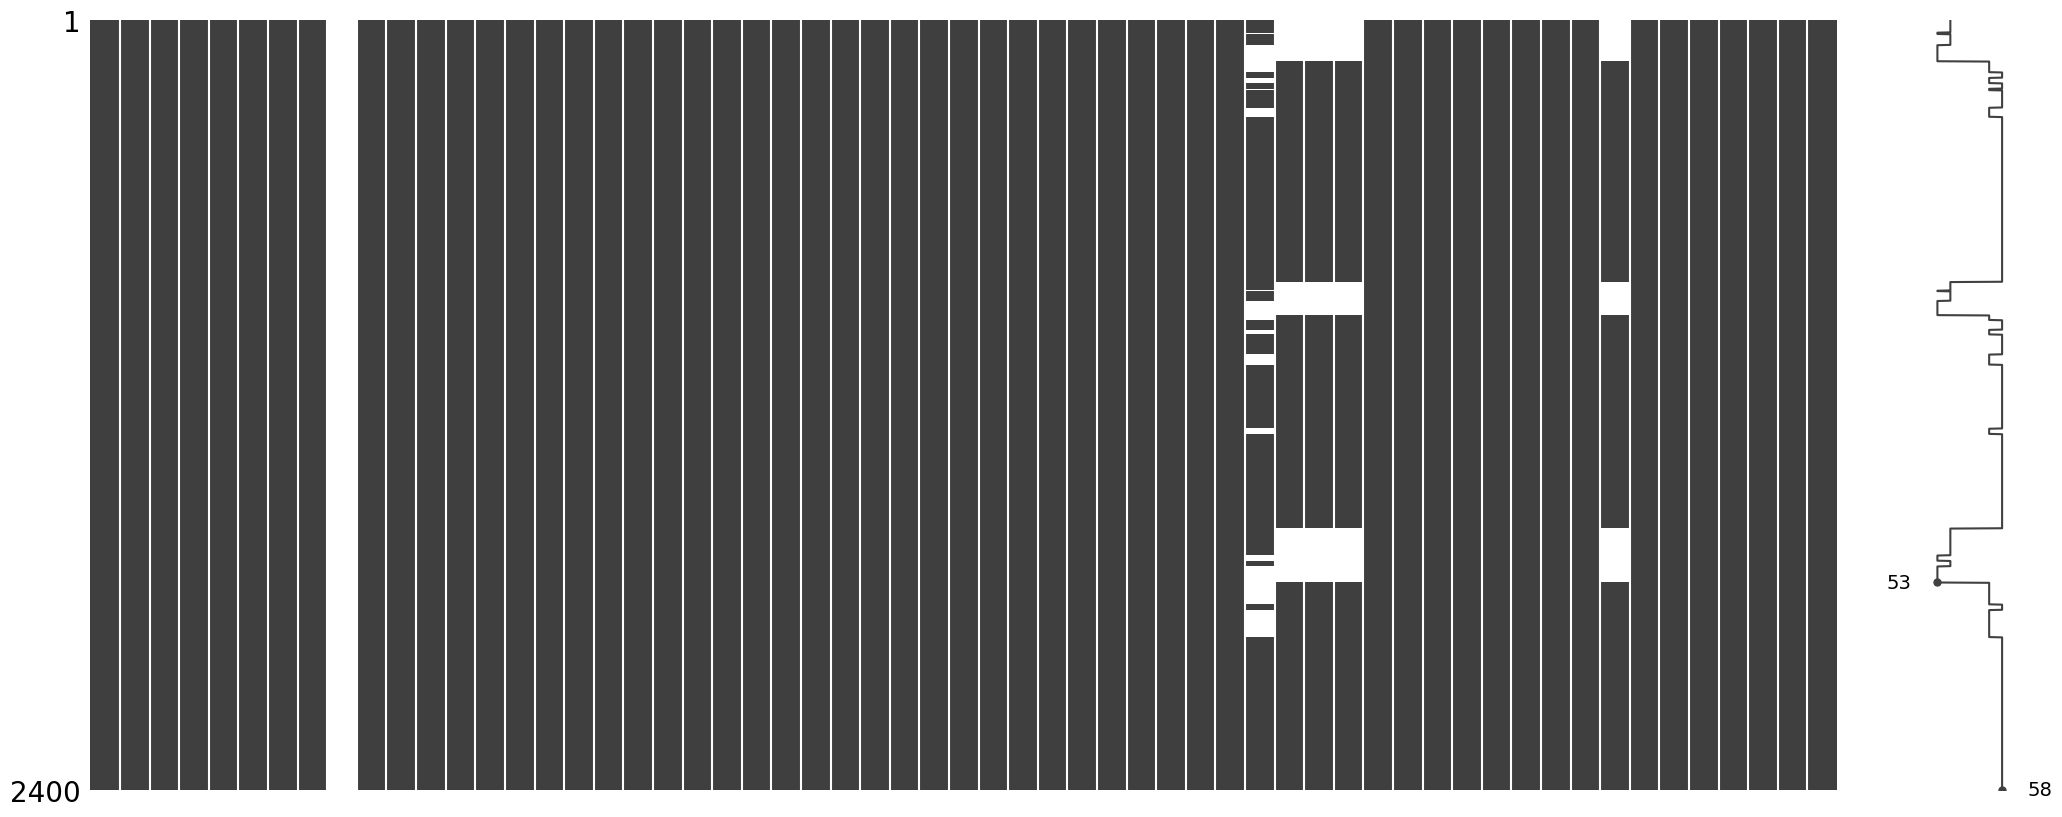

In [38]:
msno.matrix(df)

In [39]:
# Count number of null values in the DataFrame by columns total and percentage
total = df.isnull().sum()
percent = total / df.shape[0] * 100
total.name = 'Total'
percent.name = 'Percent'
# Merge both Series and sort it
missing_data = pd.merge(total, percent, right_index=True, left_index=True)
missing_data = missing_data.round(1).sort_values('Total', axis='rows', ascending=False)
missing_data[missing_data['Total'] > 0]

,Total,Percent
Predicted Rice Yield (kg/ha),2400,100.0
preciptype,488,20.3
severerisk,402,16.8
snow,402,16.8
snowdepth,402,16.8
windgust,402,16.8


In [40]:
df['preciptype'].fillna('None', inplace=True)
df['preciptype'].describe()

count     2400
unique       2
top       rain
freq      1912
Name: preciptype, dtype: object

## Renaming & Typing

In [41]:
# Rename columns
# df.rename(
#     {
#         "District": "district", 
#         "Latitude": "lat", 
#         "Longitude": "lon",
#         "Season(SA = Summer Autumn, WS = Winter Spring)": "season",
#         "Rice Crop Intensity(D=Double, T=Triple)": "intensity",
#         "Date of Harvest": "harvest",
#         "Field size (ha)": "size",
#         "Rice Yield (kg/ha)": "yield",
#         "ID No": "id_no"
#     },
#     axis="columns", inplace=True)

# Set the type of each columns
df = df.astype(
    dtype={
        # "id_no": "category",
        "Rice Crop Intensity(D=Double, T=Triple)": "category",
        "preciptype": "category",
        "conditions": 'category',
        "description": "category",
        "icon": "category",
    },
   copy=False 
)

#Remove unusuful columns
df.drop(columns=["date", 'Predicted Rice Yield (kg/ha)', 'windgust', 'snowdepth', 'snow', 'severerisk', 'stations'], inplace=True)

df.head()

,ID No,District,Latitude,Longitude,"Season(SA = Summer Autumn, WS = Winter Spring)","Rice Crop Intensity(D=Double, T=Triple)",Date of Harvest,Field size (ha),ndvi,savi,...,visibility,solarradiation,solarenergy,uvindex,sunrise,sunset,moonphase,conditions,description,icon
0,35,Chau_Phu,10.473786,105.190479,WS,T,03-04-2022,1.7,-0.016555,0.991723,...,11.1,115.1,9.9,4,2021-11-08T05:51:57,2021-11-08T17:33:28,0.11,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain
1,91,Chau_Phu,10.490352,105.230650,WS,T,02-04-2022,4.0,-0.000463,0.999769,...,11.1,115.1,9.9,4,2021-11-08T05:51:57,2021-11-08T17:33:28,0.11,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain
2,39,Chau_Phu,10.477062,105.168941,WS,D,03-04-2022,3.4,-0.021732,0.989135,...,11.1,115.1,9.9,4,2021-11-08T05:51:57,2021-11-08T17:33:28,0.11,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain
3,85,Chau_Phu,10.469839,105.211568,WS,T,01-04-2022,4.0,-0.007756,0.996122,...,11.1,115.1,9.9,4,2021-11-08T05:51:57,2021-11-08T17:33:28,0.11,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain
4,10,Chau_Phu,10.523312,105.286299,WS,T,01-04-2022,3.0,-0.007401,0.996299,...,11.1,115.1,9.9,4,2021-11-08T05:51:57,2021-11-08T17:33:28,0.11,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain


# Feature Engineering

## Categorical Data

In [42]:
df = pd.merge(df, pd.get_dummies(df[['description', 'preciptype', 'conditions', 'icon']]), left_index=True, right_index=True)
df.drop(columns=['description', 'preciptype', 'conditions', 'icon'])
df.head()

,ID No,District,Latitude,Longitude,"Season(SA = Summer Autumn, WS = Winter Spring)","Rice Crop Intensity(D=Double, T=Triple)",Date of Harvest,Field size (ha),ndvi,savi,...,description_Partly cloudy throughout the day with morning rain.,description_Partly cloudy throughout the day with rain clearing later.,description_Partly cloudy throughout the day with rain.,description_Partly cloudy throughout the day.,preciptype_None,preciptype_rain,conditions_Partially cloudy,"conditions_Rain, Partially cloudy",icon_partly-cloudy-day,icon_rain
0,35,Chau_Phu,10.473786,105.190479,WS,T,03-04-2022,1.7,-0.016555,0.991723,...,0,0,1,0,0,1,0,1,0,1
0,35,Chau_Phu,10.473786,105.190479,WS,T,03-04-2022,1.7,-0.016555,0.991723,...,0,0,1,0,0,1,0,1,0,1
0,35,Chau_Phu,10.473786,105.190479,WS,T,03-04-2022,1.7,-0.016555,0.991723,...,0,0,0,0,0,1,0,1,0,1
0,52,Thoai_Son,10.303437,105.381252,WS,T,28-03-2022,2.1,-0.027088,0.986457,...,0,0,1,0,0,1,0,1,0,1
0,52,Thoai_Son,10.303437,105.381252,WS,T,28-03-2022,2.1,-0.027088,0.986457,...,0,0,1,0,0,1,0,1,0,1


## Numerical data

In [43]:
df['sunrise'] = pd.to_datetime(df['sunrise'])
df['sunset'] = pd.to_datetime(df['sunset'])

df['solarexposure'] = df['sunset'] - df['sunrise']
df['solarexposure'] = df['solarexposure'].dt.total_seconds()

df.drop(columns=['sunrise', 'sunset'], inplace=True)

df['solarexposure'].describe()

count     7104.000000
mean     44058.924831
std       1447.771441
min      41417.000000
25%      42660.000000
50%      44588.000000
75%      45082.000000
max      45871.000000
Name: solarexposure, dtype: float64

In [44]:
df = df.groupby(['District', 'Latitude', 'Longitude',
       'Season(SA = Summer Autumn, WS = Winter Spring)',
       'Rice Crop Intensity(D=Double, T=Triple)', 'Date of Harvest',
       'Field size (ha)', 'ID No']).describe()

df.columns = df.columns.map('_'.join).str.strip('_')

In [45]:
df.reset_index(level=["Field size (ha)", "Rice Crop Intensity(D=Double, T=Triple)"], inplace=True)

In [46]:
df.head()

Rice Crop Intensity(D=Double, T=Triple)  \
District Latitude  Longitude  Season(SA = Summer Autumn, WS = Winter Spring) Date of Harvest ID No                                           
Chau_Phu 10.441423 105.115088 SA                                             20-07-2022      17                                          D   
         10.469839 105.211568 WS                                             01-04-2022      85                                          T   
         10.473786 105.190479 SA                                             14-07-2022      13                                          T   
                              WS                                             03-04-2022      35                                          T   
         10.474439 105.216928 SA                                             15-07-2022      81                                          T   

                                                                                                    Field size (ha)  \
District Latitude  Longitude  Season(SA = Summer Autumn, WS = Winter Spring) Date of Harvest ID No                    
Chau_Phu 10.441423 105.115088 SA                                             20-07-2022      17                 4.0   
         10.469839 105.211568 WS                                             01-04-2022      85                 4.0   
         10.473786 105.190479 SA                                             14-07-2022      13                 1.7   
                              WS                                             03-04-2022      35                 1.7   
         10.474439 105.216928 SA                                             15-07-2022      81                 7.0   

                                                                                                    ndvi_count  \
District Latitude  Longitude  Season(SA = Summer Autumn, WS = Winter Spring) Date of Harvest ID No               
Chau_Phu 10.441423 105.115088 SA                                             20-07-2022      17           70.0   
         10.469839 105.211568 WS                                             01-04-2022      85           71.0   
         10.473786 105.190479 SA                                             14-07-2022      13           70.0   
                              WS                                             03-04-2022      35           71.0   
         10.474439 105.216928 SA                                             15-07-2022      81           70.0   

                                                                                                    ndvi_mean  \
District Latitude  Longitude  Season(SA = Summer Autumn, WS = Winter Spring) Date of Harvest ID No              
Chau_Phu 10.441423 105.115088 SA                                             20-07-2022      17      0.250008   
         10.469839 105.211568 WS                                             01-04-2022      85      0.296828   
         10.473786 105.190479 SA                                             14-07-2022      13      0.255536   
                              WS                                             03-04-2022      35      0.331765   
         10.474439 105.216928 SA                                             15-07-2022      81      0.247466   

                                                                                                    ndvi_std  \
District Latitude  Longitude  Season(SA = Summer Autumn, WS = Winter Spring) Date of Harvest ID No             
Chau_Phu 10.441423 105.115088 SA                                             20-07-2022      17     0.227205   
         10.469839 105.211568 WS                                             01-04-2022      85     0.239650   
         10.473786 105.190479 SA                                             14-07-2022      13     0.230853   
                              WS                                             03-04-2022      35     0.267889   
       

# Data Preparation

In [47]:
# Split Features & Target
X = df

## Convert Categorical features

In [48]:
# Convert categorical variable into dummy/indicator variables
X = pd.get_dummies(X, drop_first=True)
X.head()

Field size (ha)  \
District Latitude  Longitude  Season(SA = Summer Autumn, WS = Winter Spring) Date of Harvest ID No                    
Chau_Phu 10.441423 105.115088 SA                                             20-07-2022      17                 4.0   
         10.469839 105.211568 WS                                             01-04-2022      85                 4.0   
         10.473786 105.190479 SA                                             14-07-2022      13                 1.7   
                              WS                                             03-04-2022      35                 1.7   
         10.474439 105.216928 SA                                             15-07-2022      81                 7.0   

                                                                                                    ndvi_count  \
District Latitude  Longitude  Season(SA = Summer Autumn, WS = Winter Spring) Date of Harvest ID No               
Chau_Phu 10.441423 105.115088 SA                                             20-07-2022      17           70.0   
         10.469839 105.211568 WS                                             01-04-2022      85           71.0   
         10.473786 105.190479 SA                                             14-07-2022      13           70.0   
                              WS                                             03-04-2022      35           71.0   
         10.474439 105.216928 SA                                             15-07-2022      81           70.0   

                                                                                                    ndvi_mean  \
District Latitude  Longitude  Season(SA = Summer Autumn, WS = Winter Spring) Date of Harvest ID No              
Chau_Phu 10.441423 105.115088 SA                                             20-07-2022      17      0.250008   
         10.469839 105.211568 WS                                             01-04-2022      85      0.296828   
         10.473786 105.190479 SA                                             14-07-2022      13      0.255536   
                              WS                                             03-04-2022      35      0.331765   
         10.474439 105.216928 SA                                             15-07-2022      81      0.247466   

                                                                                                    ndvi_std  \
District Latitude  Longitude  Season(SA = Summer Autumn, WS = Winter Spring) Date of Harvest ID No             
Chau_Phu 10.441423 105.115088 SA                                             20-07-2022      17     0.227205   
         10.469839 105.211568 WS                                             01-04-2022      85     0.239650   
         10.473786 105.190479 SA                                             14-07-2022      13     0.230853   
                              WS                                             03-04-2022      35     0.267889   
         10.474439 105.216928 SA                                             15-07-2022      81     0.209381   

                                                                                                    ndvi_min  \
District Latitude  Longitude  Season(SA = Summer Autumn, WS = Winter Spring) Date of Harvest ID No             
Chau_Phu 10.441423 105.115088 SA                                             20-07-2022      17    -0.084184   
         10.469839 105.211568 WS                                             01-04-2022      85    -0.064512   
         10.473786 105.190479 SA                                             14-07-2022      13    -0.118930   
                              WS                                             03-04-2022      35    -0.066037   
         10.474439 105.216928 SA                                             15-07-2022      81    -0.070309   

                                                                                                    ndvi_

# Load the model

In [49]:
model_filename = "../model/adaptative/xgboost.save"
model = joblib.load(model_filename)

In [50]:
y_pred = model.predict(X)

In [51]:
s_pred = pd.Series(y_pred, index=df.index, name='Predicted Rice Yield (kg/ha)')

# Load Submissions file

In [52]:
df_sub = pd.read_csv("../../data/raw/test.csv")
df_sub.drop(columns='Predicted Rice Yield (kg/ha)', inplace=True)
df_sub.head()

,ID No,District,Latitude,Longitude,"Season(SA = Summer Autumn, WS = Winter Spring)","Rice Crop Intensity(D=Double, T=Triple)",Date of Harvest,Field size (ha)
0,1,Chau_Phu,10.542192,105.187920,WS,T,10-04-2022,1.40
1,2,Chau_Thanh,10.400189,105.331053,SA,T,15-07-2022,1.32
2,3,Chau_Phu,10.505489,105.203926,SA,D,14-07-2022,1.40
3,4,Chau_Phu,10.523520,105.138274,WS,D,10-04-2022,1.80
4,5,Thoai_Son,10.294660,105.248528,SA,T,20-07-2022,2.20


In [53]:
df_sub = pd.merge(df_sub, s_pred, on="ID No")
df_sub.head()

,ID No,District,Latitude,Longitude,"Season(SA = Summer Autumn, WS = Winter Spring)","Rice Crop Intensity(D=Double, T=Triple)",Date of Harvest,Field size (ha),Predicted Rice Yield (kg/ha)
0,1,Chau_Phu,10.542192,105.187920,WS,T,10-04-2022,1.40,7344.078613
1,2,Chau_Thanh,10.400189,105.331053,SA,T,15-07-2022,1.32,5946.680664
2,3,Chau_Phu,10.505489,105.203926,SA,D,14-07-2022,1.40,5941.944336
3,4,Chau_Phu,10.523520,105.138274,WS,D,10-04-2022,1.80,7281.490234
4,5,Thoai_Son,10.294660,105.248528,SA,T,20-07-2022,2.20,5691.092285


In [54]:
sub_filename = '../model/adaptative/submission.csv'
df_sub.to_csv(sub_filename, index=False, header=True)